# Exploratory Data Analysis voor project "Gezondheidszorg"

## Imports van de te gebruiken libraries

In [477]:
import pandas as pd
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

## Ophalen van de data

De data kan op verschillende manieren worden opgehaald; we zullen drie manieren bekijken. Voor de API variant dient de rest server te zijn opgestart via het gekregen bash script. Tot op heden heb ik nog geen manier gevonden om dit in een notebook te doen. We gaan er voor deze optie dus vanuit dat de rest server opgestart is. Als dit niet zo is werkt het onderstaande blok code niet. 

### Data ophalen via rest API

In [478]:
#url van API
url = "http://localhost:8080/medish_centrum_randstad/api/netlify?page=1"

#We slaan de response op 
response = requests.get(url).json()

#We slaan de response['data'] op als dataframe
df_api = pd.DataFrame(response['data'])

#We bekijken de descriptive statistics van de dataset
df_api.describe()

genetic       length         mass     exercise      smoking  \
count  4095.000000  4093.000000  4094.000000  4095.000000  4096.000000   
mean     81.819780   183.880283    91.813385     1.947009     9.376953   
std       7.451307    12.623054    25.791253     1.203064     6.899523   
min      63.000000   154.000000    50.000000     0.000000     0.000000   
25%      77.000000   175.000000    71.000000     1.000000     3.000000   
50%      81.000000   184.000000    89.000000     2.000000     9.000000   
75%      86.000000   193.000000   110.000000     3.000000    15.000000   
max     102.000000   214.000000   163.000000     5.000000    22.000000   

           alcohol        sugar     lifespan  
count  4094.000000  4095.000000  4094.000000  
mean      1.818759     6.031013    79.719834  
std       1.816363     2.726548     7.845809  
min       0.000000     0.000000    57.000000  
25%       0.000000     4.000000    75.000000  
50%       1.000000     6.000000    79.000000  
75%       4.000000     8.000000    85.000000  
max       6.000000    13.000000   105.000000

### Data ophalen met een SQLite query:

In [479]:
#We specificeren een pad en de table naam van de table die we willen opvragen
dbName = "rest_server/medisch_centrum_randstad/db.sqlite3"
tableName = "rest_api_netlify"

#We maken een connectie
dbConnection = sqlite3.connect(dbName)

#We doen een query en maken hier een pandas dataframe van
df_db = pd.read_sql_query(f"SELECT * FROM {tableName}", dbConnection)

#We sluiten de connectie
dbConnection.close()

#Bekijken van descriptive statistics
df_db.describe()

id      genetic       length         mass     exercise  \
count  4096.00000  4095.000000  4093.000000  4094.000000  4095.000000   
mean   2048.50000    82.268352   183.880283    92.268442     2.402125   
std    1182.55768     7.442579    12.623054    25.791314     1.170062   
min       1.00000    63.900000   154.000000    50.000000     0.100000   
25%    1024.75000    77.600000   175.000000    71.500000     1.500000   
50%    2048.50000    81.800000   184.000000    89.500000     2.200000   
75%    3072.25000    86.700000   193.000000   110.875000     3.200000   
max    4096.00000   102.200000   214.000000   163.600000     5.500000   

           smoking      alcohol     lifespan        sugar  
count  4096.000000  4094.000000  4094.000000  4095.000000  
mean      9.807446     2.264558    80.167416     6.482955  
std       6.921461     1.800523     7.841687     2.710213  
min       0.000000     0.000000    57.000000     0.700000  
25%       3.300000     0.600000    75.000000     4.400000  
50%       9.500000     1.700000    79.700000     6.300000  
75%      15.900000     4.000000    85.200000     8.400000  
max      22.200000     6.000000   105.100000    13.800000

### Ophalen van data via .csv bestand / opmerking over versies van de dataset

Er gaan op het moment van schrijven meerdere versies van de data rond - hierdoor weet ik niet meer goed welke versie er nou uiteindelijk gebruikt moet worden. 

Als oplossing heb ik dus alle drie de varianten van het ophalen in het notebook staan. Hieronder zien we de laatste manier, namelijk het inlezen van een csv. 

Het onderstaande csv bestand is de "laatste" versie die we hebben gekregen, maar deze verschilt weer van de versies die we hierboven hebben opgehaald via SQL en de API.

In [480]:
df_csv = pd.read_csv('data_new.csv')

df_csv.describe()

smoking     lifespan
count  4096.000000  4096.000000
mean      9.807446    80.127783
std       6.921461     8.042270
min       0.000000    -1.000000
25%       3.300000    75.000000
50%       9.500000    79.700000
75%      15.900000    85.200000
max      22.200000   105.100000

In de csv versie van hierboven staan, in tegenstelling tot de SQL/API versies, vraagtekens en 'undefined' cellen. Ook hebben we een aantal kolommen van het type 'object'. Het idee is natuurlijk, los van welke dataset we uiteindelijk gebruiken, om het opschoonproces af te sluiten met een dataset zonder foutjes, lege cellen en andere onwenselijkheden.

In [481]:
print(df_csv.dtypes)
print('\n')
print(df_api.dtypes)
print('\n')
print(df_db.dtypes)

genetic      object
length       object
mass         object
exercise     object
smoking     float64
alcohol      object
sugar        object
lifespan    float64
dtype: object


genetic     float64
length      float64
mass        float64
exercise    float64
smoking       int64
alcohol     float64
sugar       float64
lifespan    float64
dtype: object


id            int64
genetic     float64
length      float64
mass        float64
exercise    float64
smoking     float64
alcohol     float64
lifespan    float64
sugar       float64
dtype: object


Voordat we iets doen met de data moeten we dus besluiten welke versie we gaan gebruiken. 

Omdat het ophalen via de SQLite query de voorkeur heeft gebruiken we deze versie van de data in het huidige notebook. Om op latere momenten nog te kunnen wisselen wordt hieronder wel beschreven hoe we alledrie de versies van de data schoon kunnen maken voor gebruik.

#### Opschonen van de csv data

Zoals we hebben kunnen zien in onze eerste blik op de datasets is het de bedoeling dat alle waardes van het type int/float moeten zijn. We kijken dus eerst of we dit eenvoudig kunnen doen:

De typecasting d.m.v. _df_csv.astype(float)_ werkt niet, dan krijgen we terug dat er o.a. een '?' wordt gevonden. We moeten dus zorgen dat we de data filteren op waardes die __niet__ kunnen worden omgezet naar floats.

De onderstaan code zou moeten werken voor elke versie van ons dataframe. We checken het hele dataframe op de mogelijkheid om waardes om te zetten naar floats. Kan dit niet (dus door een "?", "undefined" of ander afwijking), dan wordt de cel leeg gemaakt. Hierbij is het goed om te noteren dat dit natuurlijk alleen maar werkt als we inderdaad een dataframe hebben waarin we enkel numerieke waardes hebben staan. Deze oplossing werkt niet als we ook categorische variabelen hebben, maar dit is in deze dataset niet het geval.

In [482]:
#In dit voorbeeld schonen we de csv versie van de data op:
for c in df_csv.columns:
    df_csv[c] = pd.to_numeric(df[c], errors='coerce')

Nu bekijken we welke rijen er allemaal een NaN bevatten, die er dus in is gezet door onze bovenstaande functie:

In [483]:
df_csv[df_csv.isna().any(axis=1)]

genetic  length  mass  exercise  smoking  alcohol  sugar  lifespan
889       NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
947       NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
1038      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
1861      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
2300      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
2354      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
2576      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
2721      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
2793      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
3043      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
3398      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN
4027      NaN     NaN   NaN       NaN      NaN      NaN    NaN       NaN

In [484]:
#Nu kunnen we de rijen verwijderen:
df_csv = df_csv.dropna()

#Checken of er nog rijen terugkomen met lege cellen:
df_csv[df_csv.isna().any(axis=1)]

Empty DataFrame
Columns: [genetic, length, mass, exercise, smoking, alcohol, sugar, lifespan]
Index: []

In [485]:
#Als we de csv versie nu bekijken zien we dat alles is omgezet naar floats:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4084 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   4084 non-null   float64
 1   length    4084 non-null   float64
 2   mass      4084 non-null   float64
 3   exercise  4084 non-null   float64
 4   smoking   4084 non-null   float64
 5   alcohol   4084 non-null   float64
 6   sugar     4084 non-null   float64
 7   lifespan  4084 non-null   float64
dtypes: float64(8)
memory usage: 287.2 KB


We hebben nu gezien hoe we het csv bestand schoon krijgen. De rest van het huidige notebook werkt met de sql-opgehaalde data.

## Bekijken van data/eerste stappen in verkennen van de data

In [486]:
#De dataset die we gebruiken
df = df_db #eerder opgehaalde dataframe

df.head()

id  genetic  length   mass  exercise  smoking  alcohol  lifespan  sugar
0   1     73.9   185.0   99.7       0.9      0.0      2.4      73.1    6.9
1   2     86.0   172.0  105.4       1.8      8.1      0.4      85.0    4.2
2   3     83.3   176.0  111.4       1.1      0.8      4.6      81.6    7.5
3   4     82.8   164.0  111.4       4.7     11.8      1.0      81.0    2.9
4   5     78.7   178.0   71.6       1.5      8.3      4.9      75.0    5.5

In deze eerste stappen bekijken we wat er in ons dataframe voorkomt qua waardes en type data:

Om te beginnen kijken we per variabel kort naar wat we hier over weten. In andere woorden: wat betekenen de waardes precies, en met welke eenheden werken we?

__id__: een variabel ter identificatie van elke rij

__genetic__: de genetische leeftijd in jaren (zonder invloed van levensstijl). Ook wel: de leeftijd die iemand zou "moeten" bereiken als levensstijl nul invloed zou hebben op de hoogte iemands levensverwachting. 

__length__: lengte in _centimeters_

__mass__: massa/gewicht in _kilogram_

__exercise__: hoeveelheid beweging in _uren per dag_

__smoking__: aantal _sigaretten per dag_

__alcohol__: aantal _glazen alcohol per dag_

__sugar__: hoeveelheid suiker in _klontjes per dag_ (volgens het voedingscentrum is één klontje ongeveer 4 gram suiker). 

__lifespan__: de uiteindelijke leeftijd die iemand heeft bereikt _met invloed van levensstijlfactoren_

In [487]:
#Voordat we verder kijken droppen de de id kolom:

df.drop(['id'], axis=1, inplace=True)

In [488]:
#Kijken of de data lege cellen bevat:

df.isna().sum()

genetic     1
length      3
mass        2
exercise    1
smoking     0
alcohol     2
lifespan    2
sugar       1
dtype: int64

In [489]:
#We bekijken alle rijen met een lege waarde:

df[df.isnull().any(axis=1)]

genetic  length   mass  exercise  smoking  alcohol  lifespan  sugar
889      88.1   156.0  112.9       0.7     19.5      0.9       NaN    3.0
947      82.0   193.0   68.0       1.3     17.2      NaN      75.3    1.2
1038     81.5     NaN  100.2       2.5      8.9      1.3      81.2    7.9
1861     76.7     NaN  115.9       1.1      4.8      3.1      74.4    2.9
2300     82.6   188.0   63.1       3.6     15.0      0.2       NaN    1.0
2354     74.8   183.0  123.2       2.3     13.8      NaN      70.4    8.1
2576     76.4   174.0   90.9       NaN     21.7      0.4      71.0    3.7
2721     88.9   179.0    NaN       3.1      0.2      0.5      91.5    5.1
2793     78.0   178.0   71.9       1.3      0.1      4.1      77.4    NaN
3043     66.7     NaN   74.0       2.4      0.1      2.0      67.6   10.5
3398      NaN   204.0   72.0       1.0      9.9      0.4      83.0    5.4
4027     67.3   180.0    NaN       1.6      0.0      0.4      67.9    5.3

In [490]:
#We verwijderen alle rijen met een NaN:
df.dropna(inplace=True)

#We hebben nu geen rijen meer met lege waardes
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [genetic, length, mass, exercise, smoking, alcohol, lifespan, sugar]
Index: []

We kunnen nu wat descriptive statistics van ons dataframe ophalen. Dit is handig aangezien we zo vrij snel kunnen zien of er bijvoorbeeld vreemde uitersten in de data zitten:

In [491]:
df.describe()

genetic       length         mass     exercise      smoking  \
count  4084.000000  4084.000000  4084.000000  4084.000000  4084.000000   
mean     82.278624   183.885162    92.275930     2.403477     9.809035   
std       7.441333    12.622858    25.801031     1.170426     6.918614   
min      63.900000   154.000000    50.000000     0.100000     0.000000   
25%      77.600000   175.000000    71.475000     1.500000     3.375000   
50%      81.800000   184.000000    89.500000     2.200000     9.500000   
75%      86.700000   193.000000   110.825000     3.200000    15.900000   
max     102.200000   214.000000   163.600000     5.500000    22.200000   

           alcohol     lifespan        sugar  
count  4084.000000  4084.000000  4084.000000  
mean      2.266846    80.177693     6.487169  
std       1.801044     7.840508     2.708622  
min       0.000000    57.000000     0.700000  
25%       0.600000    75.000000     4.400000  
50%       1.700000    79.700000     6.300000  
75%       4.000000    85.200000     8.400000  
max       6.000000   105.100000    13.800000

## Spotten van afwijkende waardes/outliers

Om de data verder te verkennen maken we voor elke kolom een boxplot. Zo kunnen we een eerste inschatting maken van eventuele outliers, en zien we daarnaast ook hoe de waardes per kolom verdeeld zijn. 

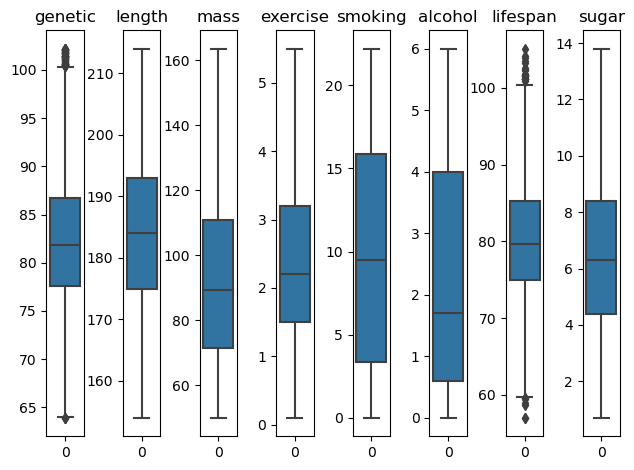

In [509]:
cols = [c for c in df.columns]

fig, axes = plt.subplots(ncols=len(cols))

for column, axis in zip(cols, axes):
        sns.boxplot(data=df[column], ax=axis) 
        axis.set_title(column)
        
plt.tight_layout(w_pad=0.2)
plt.show()

Hierboven zien we dat we alleen bij 'genetic' en 'lifespan' wat uitschieters hebben naar boven en beneden. De vraag is nu: zijn dit daadwerkelijk verkeerde datapunten, of zijn deze uitschieters "gewoon" onderdeel van de data. Er zijn immers mensen die een stuk jonger of ouder worden dan de meeste mensen. In dit geval is er besloten om deze uitschieters niet te verwijderen aangezien ze niet onwaarschijnlijk zijn, en het vrijwel zeker is dat dit echte datapunten zijn.

## Feature extraction/engineering

Nu we een redelijk schoon dataframe hebben zonder echte outliers, kunnen we kijken of we bepaalde features kunnen maken of bewerken. We beginnen met het aanmaken van een BMI kolom:

In [510]:
#We berekenen de bmi volgens de standaard formule:
df['BMI'] = df['mass'] / ((df['length'])/100)**2

#We kijken naar onze nieuwe variabel
df['BMI'].describe()

count    4084.000000
mean       27.682015
std         8.711661
min        11.320500
25%        20.938542
50%        26.476726
75%        33.207260
max        65.869494
Name: BMI, dtype: float64

Vervolgens kunnen we, volgens de categorieën van het voedingscentrum (https://www.voedingscentrum.nl/nl/bmi-meter), een grouping variabel maken voor BMI. 

In [511]:
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['BMI cat'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,70], labels=labels)

We bekijken de aantallen voor de nieuw gemaakte kolom:

In [563]:
df['BMI cat'].value_counts()

Obese          1487
Normal         1151
Overweight      851
Underweight     595
Name: BMI cat, dtype: int64

<Figure size 1000x1000 with 0 Axes>

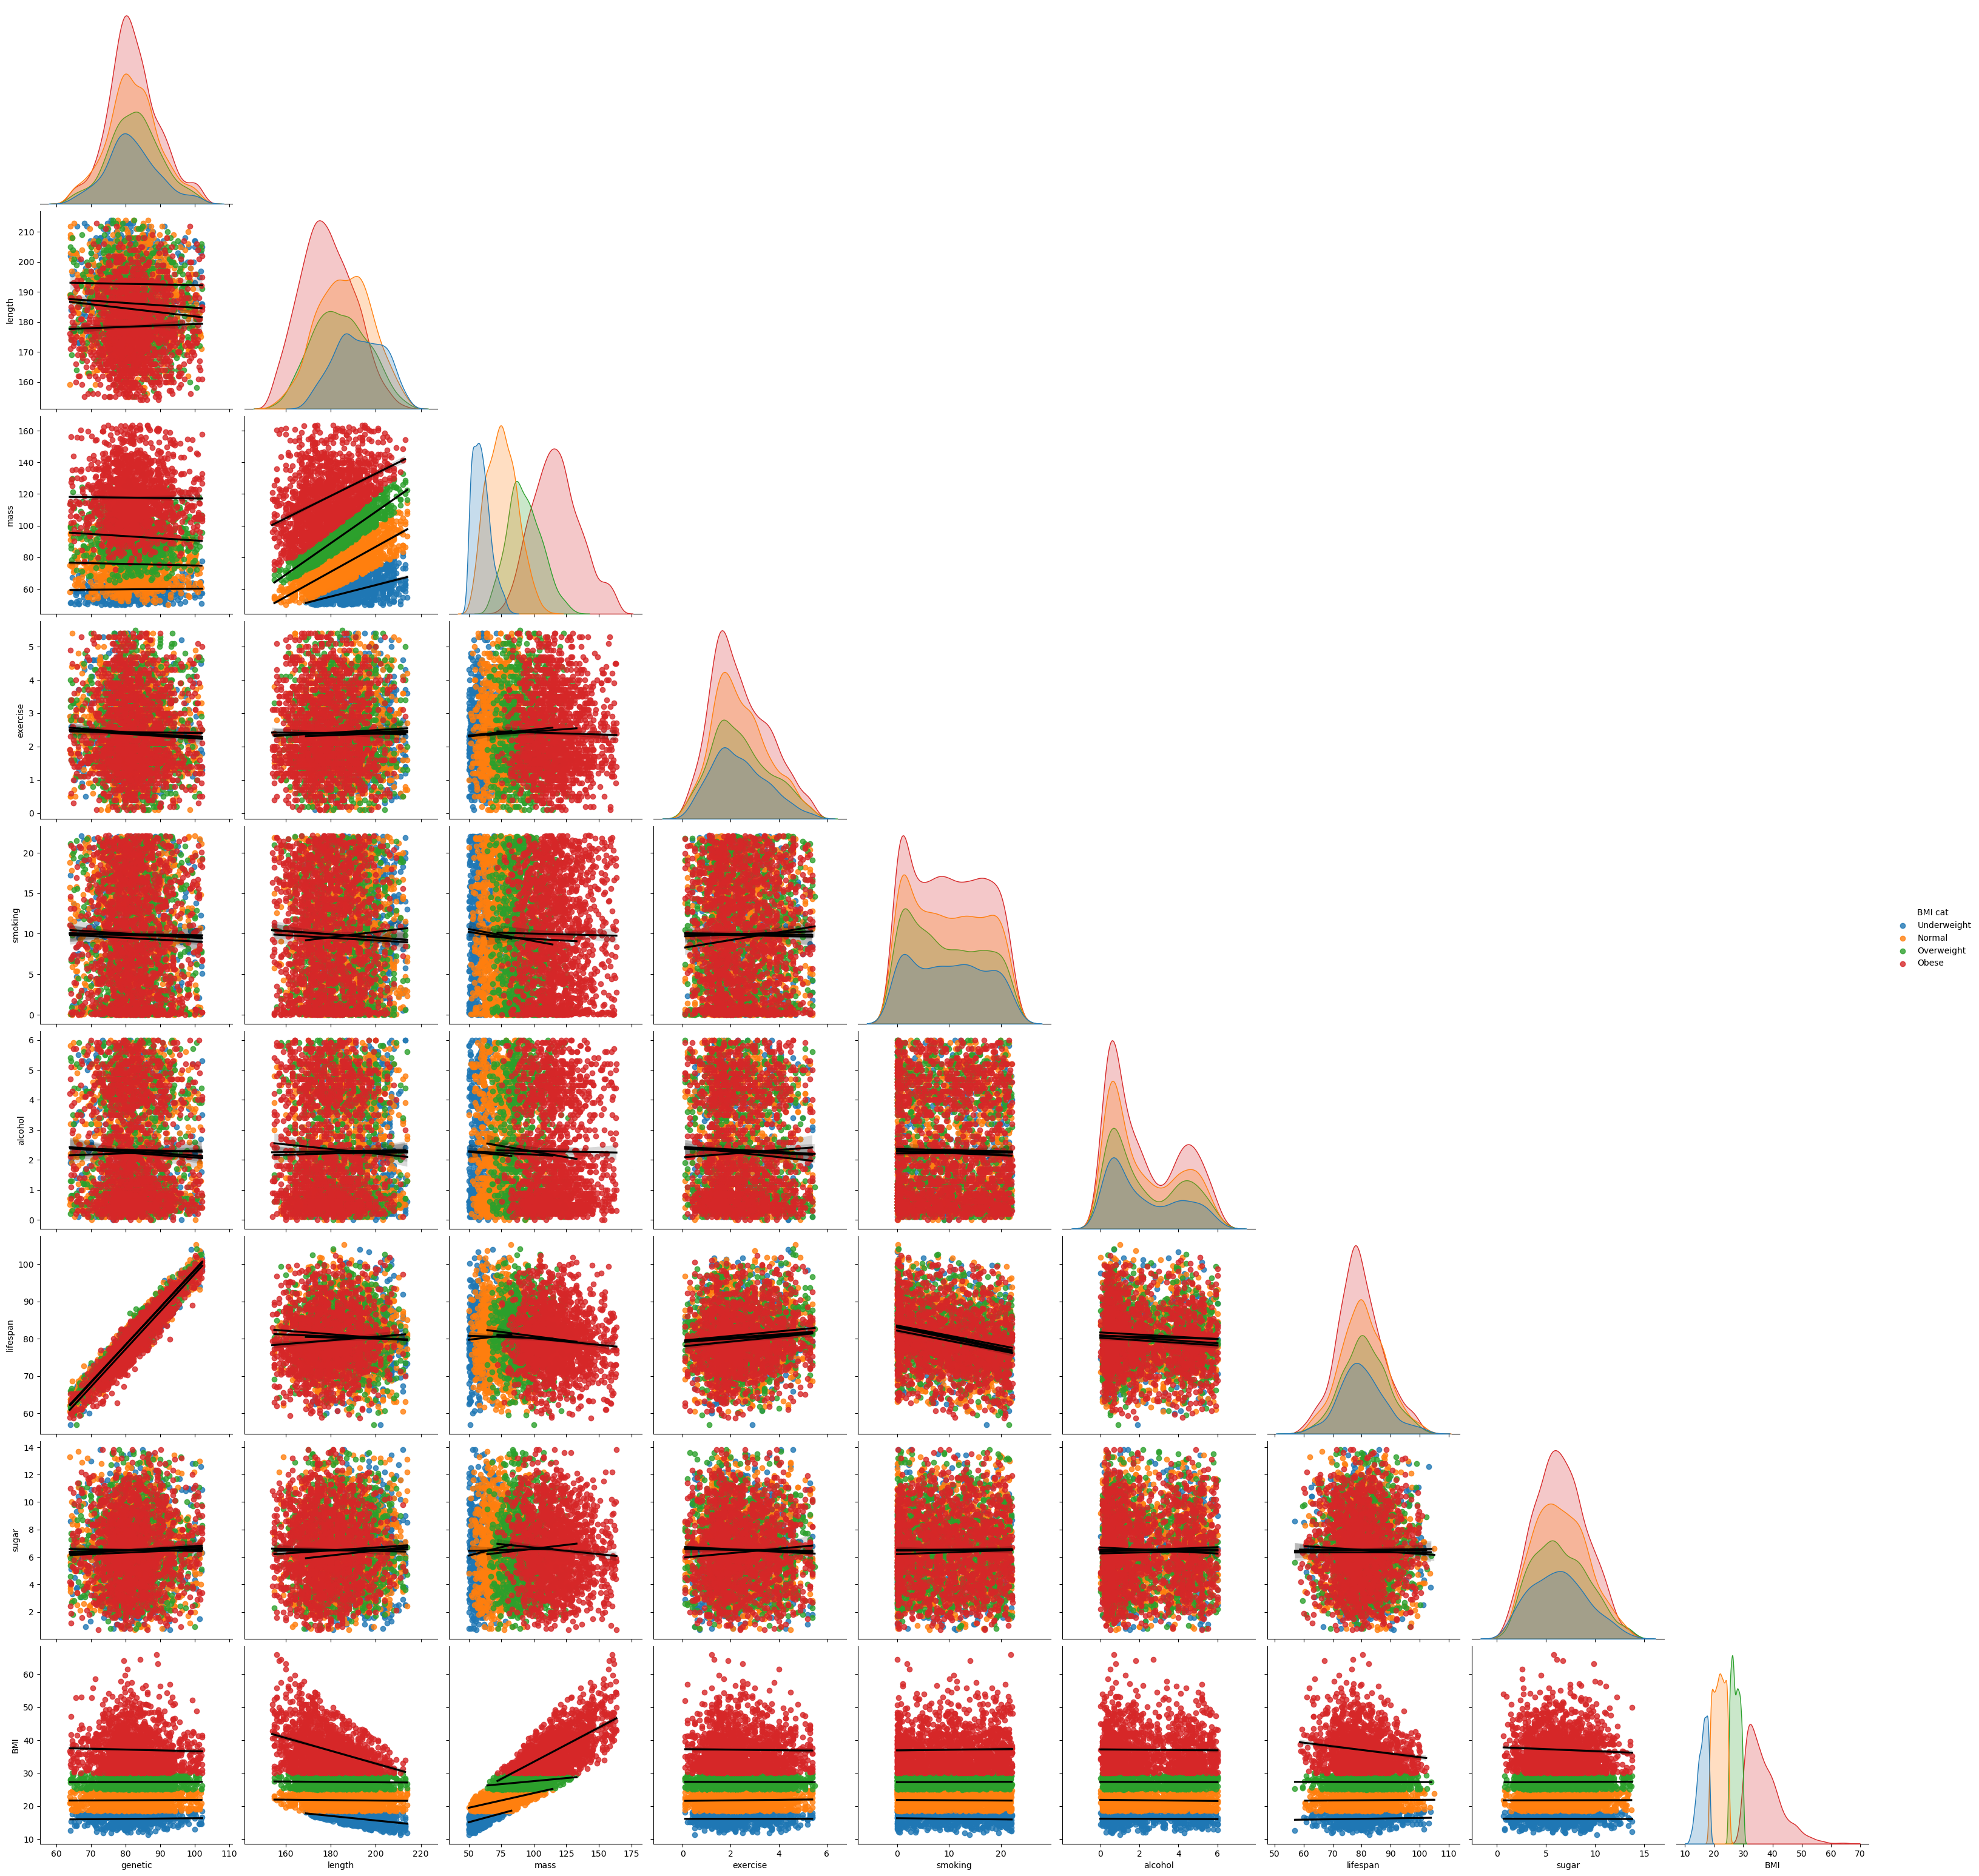

<Figure size 1000x1000 with 0 Axes>

In [458]:
sns.pairplot(df, kind='reg', corner=True, plot_kws={'line_kws':{'color':'black'}}, hue='BMI cat', height = 3.5)
plt.figure(figsize=(10, 10))